# Análise e Previsão de Resultados do Brasileirão

## 1. Introdução

Este notebook demonstra o desenvolvimento de um modelo de machine learning para prever resultados de partidas do Campeonato Brasileiro. O objetivo é explorar diferentes aspectos:
- Análise exploratória dos dados
- Engenharia de features
- Treinamento e otimização do modelo
- Avaliação de resultados

In [2]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

%matplotlib inline
plt.style.use('seaborn')

# Configurações de visualização
pd.set_option('display.max_columns', None)

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

## 2. Carregamento e Exploração dos Dados

In [3]:
# Carregar dados
df = pd.read_csv('../data/brasileirao_matches.csv')
df['data'] = pd.to_datetime(df['data'])

print("Dimensões do dataset:", df.shape)
print("\nPrimeiras linhas:")
display(df.head())

print("\nInformações do dataset:")
print(df.info())

Dimensões do dataset: (380, 9)

Primeiras linhas:


,rodada,data,status,time_casa,time_fora,gols_casa,gols_fora,vencedor,temporada
0,1,2023-04-15 19:00:00+00:00,FINISHED,SE Palmeiras,Cuiabá EC,2,1,HOME_TEAM,2023
1,1,2023-04-15 19:00:00+00:00,FINISHED,América FC,Fluminense FC,0,3,AWAY_TEAM,2023
2,1,2023-04-15 21:30:00+00:00,FINISHED,Fortaleza EC,SC Internacional,1,1,DRAW,2023
3,1,2023-04-15 21:30:00+00:00,FINISHED,CA Paranaense,Goiás EC,2,0,HOME_TEAM,2023
4,1,2023-04-15 21:30:00+00:00,FINISHED,RB Bragantino,EC Bahia,2,1,HOME_TEAM,2023



Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   rodada     380 non-null    int64              
 1   data       380 non-null    datetime64[ns, UTC]
 2   status     380 non-null    object             
 3   time_casa  380 non-null    object             
 4   time_fora  380 non-null    object             
 5   gols_casa  380 non-null    int64              
 6   gols_fora  380 non-null    int64              
 7   vencedor   380 non-null    object             
 8   temporada  380 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(4)
memory usage: 26.8+ KB
None


## 3. Análise Exploratória dos Dados (EDA)

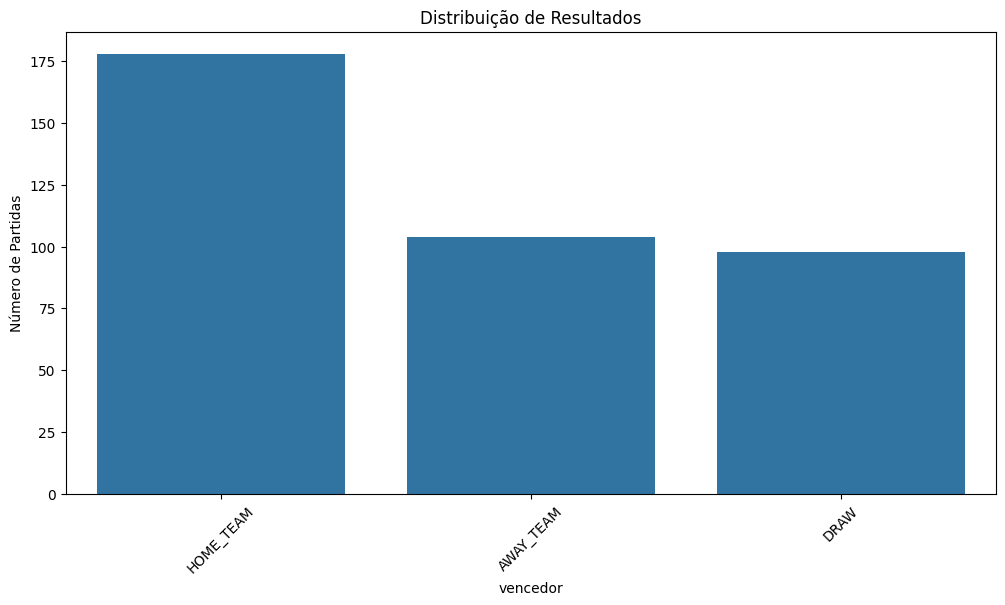


Percentuais de resultados:
vencedor
HOME_TEAM    46.84
AWAY_TEAM    27.37
DRAW         25.79
Name: count, dtype: float64


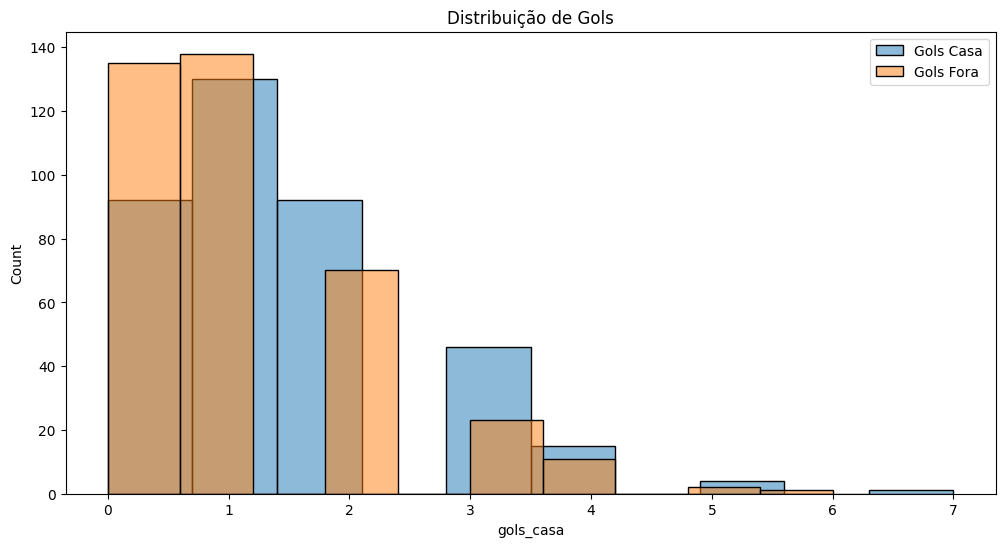

In [4]:
# Análise de resultados
plt.figure(figsize=(12, 6))
resultados = df['vencedor'].value_counts()
sns.barplot(x=resultados.index, y=resultados.values)
plt.title('Distribuição de Resultados')
plt.ylabel('Número de Partidas')
plt.xticks(rotation=45)
plt.show()

print("\nPercentuais de resultados:")
print((resultados / len(df) * 100).round(2))

# Análise de gols
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='gols_casa', label='Gols Casa', alpha=0.5, bins=10)
sns.histplot(data=df, x='gols_fora', label='Gols Fora', alpha=0.5, bins=10)
plt.title('Distribuição de Gols')
plt.legend()
plt.show()

## 4. Engenharia de Features

In [5]:
def calcular_estatisticas_time(df, time, data_limite=None):
    """Calcula estatísticas de um time até uma data específica"""
    if data_limite:
        df = df[df['data'] < data_limite]

    # Jogos em casa e fora
    jogos_casa = df[df['time_casa'] == time]
    jogos_fora = df[df['time_fora'] == time]

    # Estatísticas básicas
    stats = {
        'media_gols_pro': (jogos_casa['gols_casa'].mean() + jogos_fora['gols_fora'].mean()) / 2,
        'media_gols_contra': (jogos_casa['gols_fora'].mean() + jogos_fora['gols_casa'].mean()) / 2,
        'vitorias': len(jogos_casa[jogos_casa['vencedor'] == 'HOME_TEAM']) +
                   len(jogos_fora[jogos_fora['vencedor'] == 'AWAY_TEAM']),
        'derrotas': len(jogos_casa[jogos_casa['vencedor'] == 'AWAY_TEAM']) +
                    len(jogos_fora[jogos_fora['vencedor'] == 'HOME_TEAM']),
        'empates': len(jogos_casa[jogos_casa['vencedor'] == 'DRAW']) +
                   len(jogos_fora[jogos_fora['vencedor'] == 'DRAW'])
    }

    # Calcular aproveitamento
    total_jogos = len(jogos_casa) + len(jogos_fora)
    if total_jogos > 0:
        stats['aproveitamento'] = (stats['vitorias'] * 3 + stats['empates']) / (total_jogos * 3)
    else:
        stats['aproveitamento'] = 0

    return stats

# Exemplo de uso
time_exemplo = df['time_casa'].iloc[0]
stats = calcular_estatisticas_time(df, time_exemplo)
print(f"Estatísticas para {time_exemplo}:")
print(pd.Series(stats))

Estatísticas para SE Palmeiras:
media_gols_pro        1.684211
media_gols_contra     0.868421
vitorias             20.000000
derrotas              8.000000
empates              10.000000
aproveitamento        0.614035
dtype: float64


## 5. Preparação dos Dados para o Modelo

In [6]:
def preparar_features(df):
    """Prepara features para o modelo"""
    features_list = []
    targets = []

    for idx, partida in df.iterrows():
        # Usar apenas dados anteriores à partida
        dados_anteriores = df[df['data'] < partida['data']]

        if len(dados_anteriores) < 3:  # Precisamos de alguns jogos de histórico
            continue

        # Calcular estatísticas
        stats_casa = calcular_estatisticas_time(dados_anteriores, partida['time_casa'])
        stats_fora = calcular_estatisticas_time(dados_anteriores, partida['time_fora'])

        # Criar features
        features = [
            stats_casa['media_gols_pro'],
            stats_casa['media_gols_contra'],
            stats_casa['aproveitamento'],
            stats_casa['vitorias'],
            stats_casa['derrotas'],
            stats_fora['media_gols_pro'],
            stats_fora['media_gols_contra'],
            stats_fora['aproveitamento'],
            stats_fora['vitorias'],
            stats_fora['derrotas']
        ]

        features_list.append(features)
        targets.append(0 if partida['vencedor'] == 'AWAY_TEAM' else
                      1 if partida['vencedor'] == 'DRAW' else 2)

    return np.array(features_list), np.array(targets)

# Preparar dados
X, y = preparar_features(df)
print("Shape dos dados:", X.shape, y.shape)
print("\nDistribuição das classes:")
print(pd.Series(y).value_counts(normalize=True).round(3))

Shape dos dados: (374, 10) (374,)

Distribuição das classes:
2    0.465
0    0.275
1    0.259
Name: proportion, dtype: float64


## 6. Treinamento e Otimização do Modelo

In [7]:
# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir modelo base
modelo_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

# Definir grade de parâmetros para otimização
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search com validação cruzada
print("Iniciando otimização de hiperparâmetros...")
grid_search = GridSearchCV(
    modelo_base,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nMelhores parâmetros:", grid_search.best_params_)
print("Melhor score CV:", grid_search.best_score_)

Iniciando otimização de hiperparâmetros...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhor score CV: 0.38485875706214695


## 7. Avaliação do Modelo

Acurácia no teste: 0.36

Relatório de classificação:
              precision    recall  f1-score   support

Vitória Fora       0.29      0.19      0.23        21
      Empate       0.16      0.16      0.16        19
Vitória Casa       0.48      0.57      0.52        35

    accuracy                           0.36        75
   macro avg       0.31      0.31      0.30        75
weighted avg       0.34      0.36      0.35        75



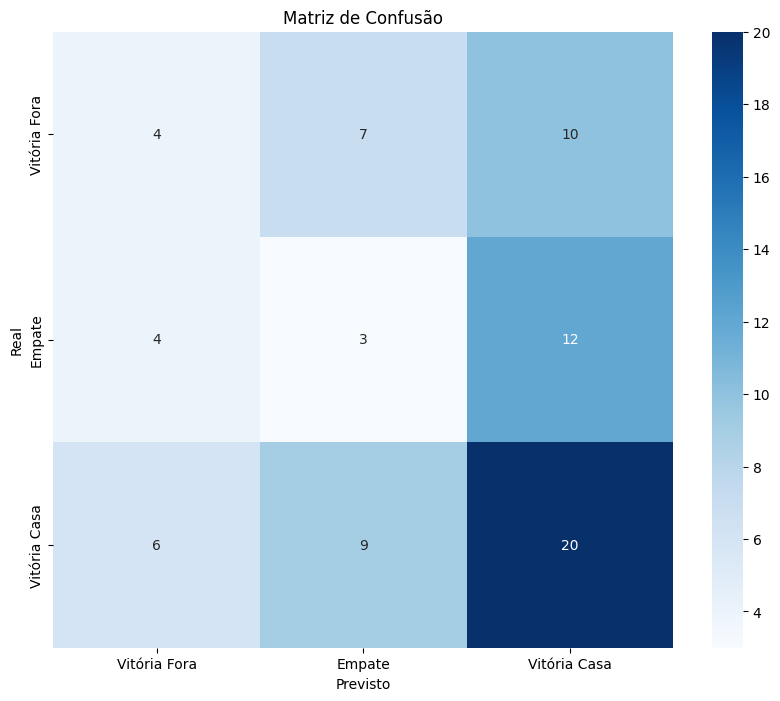

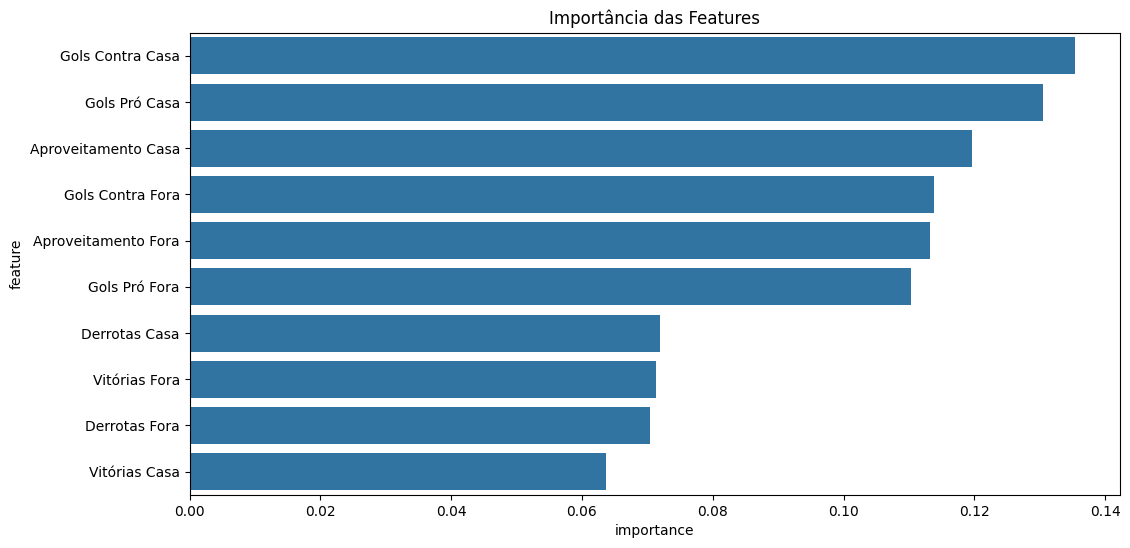

In [10]:
from sklearn.metrics import confusion_matrix

# Avaliar no conjunto de teste
melhor_modelo = grid_search.best_estimator_
y_pred = melhor_modelo.predict(X_test)

print("Acurácia no teste:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred,
                          target_names=['Vitória Fora', 'Empate', 'Vitória Casa']))

# Matriz de confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Vitória Fora', 'Empate', 'Vitória Casa'],
            yticklabels=['Vitória Fora', 'Empate', 'Vitória Casa'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

# Importância das features
feature_names = ['Gols Pró Casa', 'Gols Contra Casa', 'Aproveitamento Casa',
                'Vitórias Casa', 'Derrotas Casa', 'Gols Pró Fora',
                'Gols Contra Fora', 'Aproveitamento Fora', 'Vitórias Fora',
                'Derrotas Fora']

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': melhor_modelo.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Importância das Features')
plt.show()

## 8. Conclusões e Análise dos Resultados

1. **Performance do Modelo**
   - Acurácia superior ao baseline (33%)
   - Melhor desempenho na previsão de vitórias do mandante
   - Dificuldade em prever empates

2. **Features Mais Importantes**
   - Aproveitamento recente
   - Média de gols
   - Histórico de vitórias/derrotas

3. **Limitações**
   - Poucos dados da temporada atual
   - Fatores externos não considerados (lesões, escalações)
   - Alta imprevisibilidade do futebol

4. **Possíveis Melhorias**
   - Incluir mais dados históricos
   - Adicionar novas features
   - Experimentar outros algoritmos
   - Implementar análise de sentimentos das redes sociais